# Result - Analysis Debugging Validation Experiment
This notebook has the goal of evaluating the retriever perfromance in RAG by the following metrics:
- Generaiton Rouge-L metric
- #gold doc in 120
- #gold doc in 16

## Main Results

* RAG:

In [8]:
import polars as pl
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from experiments.prompt_analysis_recall.run_rag import INSTRUCTIONS
from utils.metrics.calculate_metric import calculate_agg_metric

ROOT = ".."

wiki = pl.read_ipc(f"../../../data/wiki_dump2018_nq_open/processed/wiki.feather")
gold = pl.read_ipc(f"../../../data/nq_open_gold/processed/dev.feather")
questions = pl.read_ipc(f"{ROOT}/questions.feather")


Could not memory_map compressed IPC file, defaulting to normal read. Toggle off 'memory_map' to silence this warning.


## RAG

In [5]:
## For each experiment, calculate rouge_l metric for each questions

LOAD = True

if not LOAD:

    rag_dfs_generations = []
    questions_path = f"{ROOT}/questions.feather"
    for file in os.listdir(f"{ROOT}/generations"):
            if file.startswith("rag"):
                nprobe = file.split("-")[2]
                rag_dfs_generations.append(calculate_agg_metric(
                    metrics=["rouge_l"],
                    generation_path=f"{ROOT}/generations/{file}",
                    reference_path=questions_path    ,
                    saving_path=None            
                )
                .with_columns([
                    pl.lit(nprobe).alias("nprobe")
                ]))

    rag_dfs_generations = pl.concat(rag_dfs_generations)
    rag_dfs_generations.write_ipc(f"rag_dfs_generations.feather")        
else:
    rag_dfs_generations = pl.read_ipc(f"rag_dfs_generations.feather")


/tmp/ipykernel_2149558/3151721502.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Rouge-L RAG by Nprobe")


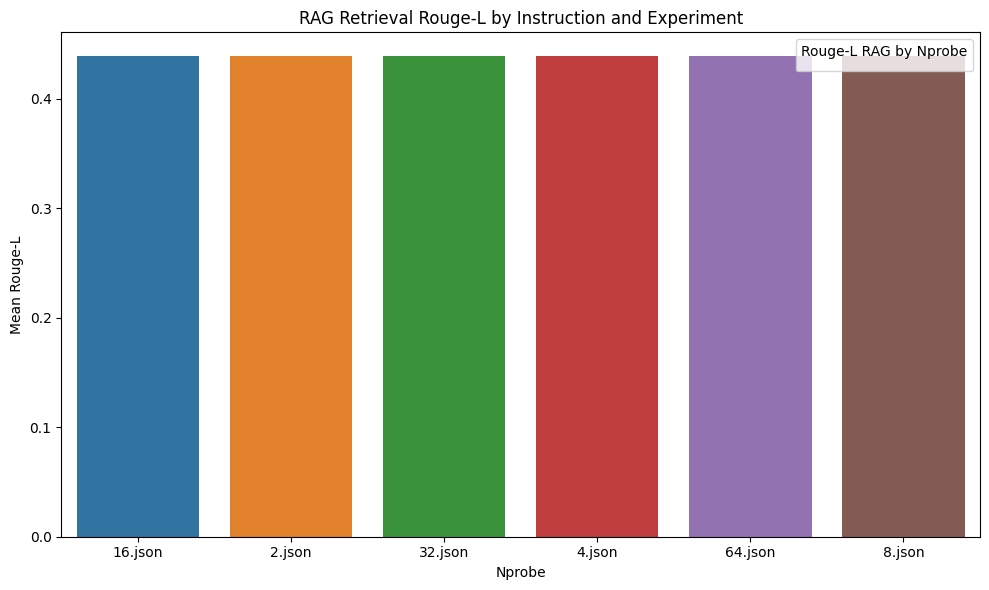

In [6]:
_rag = rag_dfs_generations.group_by(["nprobe"]).agg(pl.mean("mean")).sort(["nprobe"])

## bar plot per instruction with hue by experiment
plt.figure(figsize=(10, 6))
sns.barplot(data=_rag.to_pandas(), x="nprobe", y="mean", hue="nprobe")
plt.title("RAG Retrieval Rouge-L by Instruction and Experiment")
plt.ylabel("Mean Rouge-L")
plt.xlabel("Nprobe")
plt.legend(title="Rouge-L RAG by Nprobe")
plt.tight_layout()
plt.show()

In [7]:
_rag

nprobe,mean
str,f64
"""16.json""",0.438671
"""2.json""",0.438671
"""32.json""",0.438671
"""4.json""",0.438671
"""64.json""",0.438671
"""8.json""",0.438671


## NUmber of Gold in Top 16 and Top 120

In [9]:
questions.head()

idx,example_id,question,answers,text,idx_gold_in_corpus
u32,i64,str,list[str],str,i64
5711,8297826416784832076,"""process of removing an element…","[""pop""]","""Considered as a linear data st…",21031457
309,4398589060680652602,"""who wrote the song smooth by f…","[""Brian Kelley"", ""Jordan Schmidt"", … ""Tyler Hubbard""]","""'' Smooth '' Single by Florida…",21027885
1457,8441840064824540767,"""who play the beast in the beau…","[""Dan Stevens""]","""Beauty and the Beast is a 2017…",20979580
2750,7204208827008494698,"""when did spain win their first…","[""2010""]","""Spain is one of only eight cou…",20977445
3812,-450228645259827754,"""when does the diary of a wimpy…","[""November 7 , 2017""]","""Diary of a Wimpy Kid : The Get…",21006372


In [16]:
from pathlib import Path

retrieval_dir = Path(f"{ROOT}/retrieval")
question_gold_idx = questions.select("idx_gold_in_corpus").to_numpy().ravel()

results = []
for path in retrieval_dir.glob("*indexes.json"):
    tag = path.stem.split("_")[1]
    retrieval_indexes = json.load(path.open())

    hits_top1 = sum(question_gold_idx[i] in retrieval_indexes[str(i)][:1] for i in range(len(question_gold_idx)))
    hits_top8 = sum(question_gold_idx[i] in retrieval_indexes[str(i)][:8] for i in range(len(question_gold_idx)))
    hits_top16 = sum(question_gold_idx[i] in retrieval_indexes[str(i)][:16] for i in range(len(question_gold_idx)))
    hits_top120 = sum(question_gold_idx[i] in retrieval_indexes[str(i)][:100] for i in range(len(question_gold_idx)))

    results.append({
        "tag": tag,
        "hits_top16": hits_top16,
        "hits_top100": hits_top120,
        "hits_top8": hits_top8,
        "hits_top1": hits_top1
    })

pl.DataFrame(results)

tag,hits_top16,hits_top100,hits_top8,hits_top1
str,i64,i64,i64,i64
"""64""",216,306,183,73
"""2""",216,306,183,73
"""4""",216,306,183,73
"""32""",216,306,183,73
"""16""",216,306,183,73
"""8""",216,306,183,73
